# Game of life

This project was made by the help of my university colleague Matija Vasic and myself Mihajlo Madzarevic.


All of the blocks implement game of life with different techniques (some throught threads, other with processes).

To run these blocks yourself you can copy this code to Google colab.

Game of life is a matrix game that "simulates" cells lives.
The most basic rules are if a cell is alive and has 3 or 2 alive cells around it, it will stay alive, otherwise it will die.
If the cell is dead and has exactly 3 cells alive around it, it will become alive, otherwise it stay dead.

In each of the blocks below you can play a video to simulate n cells provided by a argument name "n" in code and for amount of "globalIterations" which is just a number of iterations in code.

# Game of life using threads

**1**. a) Implemented using Locks from class "threading".

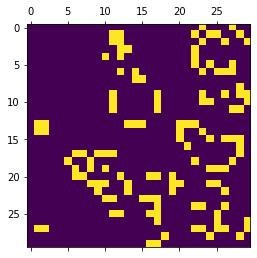

In [ ]:
import numpy as np
import threading
import time
import random

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

n = 30
globalIterations = 30
movI = [-1, -1, 0, 1, 1, 1, 0, -1]
movJ = [0, 1, 1, 1, 0, -1, -1, -1]

full = threading.Lock()
empty = threading.Lock()
mutex = threading.Lock()
mutex1 = threading.Lock()

#br iteracije
h = 0

entered = 0
exited = n**2
nextIteration = True

matrix = np.empty((n,n), dtype=object)
threadMatrix = np.empty((n,n), dtype=object)

matrixArray = np.empty((globalIterations,n,n), dtype=int)

class Cell:
    lock = threading.Lock()
    hasBeenRead = 8
    value = 0
    aliveAround = 0
    deadAround = 0

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.value = random.randint(0,1)
        if (x == 0 and y == 0) or (x == 0 and y == n-1) or (x == n-1 and y == 0) or (x == n-1 and y == n-1):
            self.hasBeenRead = 3
        elif x == 0 or x == n-1 or y == 0 or y == n-1:
            self.hasBeenRead = 5

    def read(self):
        global h
        for i in range(8):
            if n > self.x+movI[i] >= 0 and n > self.y + movJ[i] >= 0:
                currCell = matrix[self.x + movI[i], self.y + movJ[i]]
                if currCell.value == 1:
                    self.aliveAround += 1
                else:
                    self.deadAround += 1
                currCell.lock.acquire()
                #print("{0}".format(h))
                #h += 1
                #print("celija x:{0} y:{1} hasBeenRead:{2}".format(self.x+movI[i], self.y + movJ[i], currCell.hasBeenRead))
                assert currCell.hasBeenRead - 1 >= 0
                currCell.hasBeenRead -= 1
                currCell.lock.release()
            else:
                self.deadAround += 1
            if i == 7:
                while self.hasBeenRead != 0:
                    time.sleep(0.01)
                if (self.x == 0 and self.y == 0) or (self.x == 0 and self.y == n - 1) or (self.x == n - 1 and self.y == 0) or (self.x == n - 1 and self.y == n - 1):
                    self.hasBeenRead = 3
                elif self.x == 0 or self.x == n - 1 or self.y == 0 or self.y == n - 1:
                    self.hasBeenRead = 5
                else:
                    self.hasBeenRead = 8
                if self.value == 1:
                    if self.aliveAround > 3 or self.aliveAround < 2:
                        self.value = 0
                else:
                    if self.aliveAround == 3:
                        self.value = 1
                self.aliveAround = 0
                self.deadAround = 0

def fillMatrix(g):
    global matrixArray
    for i in range(n):
        for j in range(n):
            matrixArray[g][i][j] = matrix[i, j].value


def animate(steps):
    ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije)
    prikazuje razvoj sistema'''

    def init():
        im.set_data(steps[0])
        return [im]

    def animate(i):
        im.set_data(steps[i])
        return [im]

    im = plt.matshow(steps[0], interpolation='None', animated=True);

    anim = FuncAnimation(im.get_figure(), animate, init_func=init,frames=len(steps), interval=500, blit=True, repeat=False);
    return anim

def waitingRoom(i, j):
    global nextIteration
    global entered
    global exited
    global h

    for g in range(globalIterations):
        matrix[i, j].read()
        mutex.acquire()
        #print("mutex acquire")
        if entered == 0 and nextIteration:
            empty.acquire()
            #print("Iteracija {0}\n".format(g))
            nextIteration = False
            entered = 1
            #print("full acquire")
            full.acquire()
        else:
            entered += 1
            if entered == n**2:
                entered = 0
                exited = 0
                nextIteration = True
                fillMatrix(g)
                #print("full release")
                full.release()
        #print("mutex release")
        #h+=1
        #print("h:{0}".format(h))
        mutex.release()
        if not nextIteration:
            full.acquire()
            #print("full release")
            full.release()
        mutex1.acquire()
        #print("mutex1 acquire")
        exited += 1
        if exited == n**2:     
            #print("empty release")
            empty.release()
        #print("mutex1 release")
        mutex1.release()

#main
for i in range(n):
    for j in range(n):
        matrix[i, j] = Cell(i, j)
        threadMatrix[i, j] = threading.Thread(target=waitingRoom, args=(i, j))

for i in range(n):
    for j in range(n):
        threadMatrix[i, j].start()

for i in range(n):
    for j in range(n):
        threadMatrix[i, j].join()

anim = animate(matrixArray)
HTML(anim.to_html5_video())

1. b) Implemented using Locks and a Condition from class "threading".

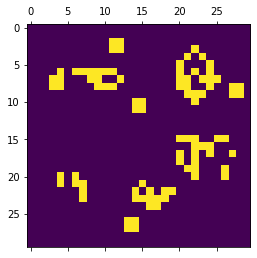

In [ ]:
import numpy as np
import threading
import time
import random

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

n = 30
globalIterations = 30
movI = [-1, -1, 0, 1, 1, 1, 0, -1]
movJ = [0, 1, 1, 1, 0, -1, -1, -1]

empty = threading.Lock()
mutex = threading.Lock()
condition = threading.Condition()
mutex1 = threading.Lock()

#br iteracije
h = 0

entered = 0
exited = n**2
nextIteration = True

matrix = np.empty((n,n), dtype=object)
threadMatrix = np.empty((n,n), dtype=object)

matrixArray = np.empty((globalIterations,n,n), dtype=int)

class Cell:
    lock = threading.Lock()
    hasBeenRead = 8
    value = 0
    aliveAround = 0
    deadAround = 0

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.value = random.randint(0,1)
        self.hasBeenRead = 8
        if (x == 0 and y == 0) or (x == 0 and y == n-1) or (x == n-1 and y == 0) or (x == n-1 and y == n-1):
            self.hasBeenRead = 3
        elif x == 0 or x == n-1 or y == 0 or y == n-1:
            self.hasBeenRead = 5

    def read(self):
        global h
        for i in range(8):
            if n > self.x+movI[i] >= 0 and n > self.y + movJ[i] >= 0:
                currCell = matrix[self.x + movI[i], self.y + movJ[i]]
                if currCell.value == 1:
                    self.aliveAround += 1
                else:
                    self.deadAround += 1
                currCell.lock.acquire()
                #print("{0}".format(h))
                #h += 1
                #print("celija x:{0} y:{1} hasBeenRead:{2}".format(self.x+movI[i], self.y + movJ[i], currCell.hasBeenRead))
                assert currCell.hasBeenRead - 1 >= 0
                currCell.hasBeenRead -= 1
                currCell.lock.release()
            else:
                self.deadAround += 1
            if i == 7:
                while self.hasBeenRead != 0:
                    time.sleep(0.01)
                if (self.x == 0 and self.y == 0) or (self.x == 0 and self.y == n - 1) or (self.x == n - 1 and self.y == 0) or (self.x == n - 1 and self.y == n - 1):
                    self.hasBeenRead = 3
                elif self.x == 0 or self.x == n - 1 or self.y == 0 or self.y == n - 1:
                    self.hasBeenRead = 5
                else:
                    self.hasBeenRead = 8
                if self.value == 1:
                    if self.aliveAround > 3 or self.aliveAround < 2:
                        self.value = 0
                    else:
                        self.value = 1
                else:
                    if self.aliveAround == 3:
                        self.value = 1
                    else:
                        self.value = 0
                self.aliveAround = 0
                self.deadAround = 0

def fillMatrix(g):
    global matrixArray
    for i in range(n):
        for j in range(n):
            matrixArray[g][i][j] = matrix[i, j].value


def animate(steps):
    ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije)
    prikazuje razvoj sistema'''

    def init():
        im.set_data(steps[0])
        return [im]

    def animate(i):
        im.set_data(steps[i])
        return [im]

    im = plt.matshow(steps[0], interpolation='None', animated=True);

    anim = FuncAnimation(im.get_figure(), animate, init_func=init,frames=len(steps), interval=500, blit=True, repeat=False);
    return anim

def waitingRoom(i, j):
    global nextIteration
    global entered
    global exited
    global h

    for g in range(globalIterations):
        matrix[i, j].read()
        mutex.acquire()
        #print("mutex acquire")
        if entered == 0 and nextIteration:
            empty.acquire()
            condition.acquire()
            #print("Iteracija {0}\n".format(g))
            nextIteration = False
            entered = 1
            #print("full acquire")
        else:
            condition.acquire()
            entered += 1
            if entered == n**2:
                entered = 0
                exited = 0
                nextIteration = True
                fillMatrix(g)
                condition.notify()
                #print("full notify prvi")
                #print("full release")
        #print("mutex release")
        mutex.release()
        if not nextIteration:
            #print("condition wait")
            condition.wait()
            condition.notify()
            #print("condition notify")
        #h += 1
        #print("h:{0}".format(h))
        condition.release()
        #print("mutex release")
        mutex1.acquire()
        exited += 1
        if exited == n**2:
            #print("empty release")
            empty.release()
        #print("mutex1 release")
        mutex1.release()

#main
for i in range(n):
    for j in range(n):
        matrix[i, j] = Cell(i, j)
        threadMatrix[i, j] = threading.Thread(target=waitingRoom, args=(i, j))

for i in range(n):
    for j in range(n):
        threadMatrix[i, j].start()

for i in range(n):
    for j in range(n):
        threadMatrix[i, j].join()

anim = animate(matrixArray)
HTML(anim.to_html5_video())



1. c) Implemented using Locks and a Barrier from class "threading".

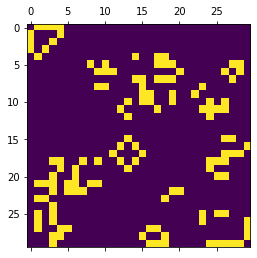

In [ ]:
import numpy as np
import threading
import time
import random

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

n = 30
globalIterations = 30
movI = [-1, -1, 0, 1, 1, 1, 0, -1]
movJ = [0, 1, 1, 1, 0, -1, -1, -1]

barrier = threading.Barrier(n**2)
empty = threading.Lock()
mutex = threading.Lock()
mutex1 = threading.Lock()

#br iteracije
h = 0

entered = 0
exited = n**2
nextIteration = True

matrix = np.empty((n,n), dtype=object)
threadMatrix = np.empty((n,n), dtype=object)

matrixArray = np.empty((globalIterations,n,n), dtype=int)

class Cell:
    lock = threading.Lock()
    hasBeenRead = 8
    value = 0
    aliveAround = 0
    deadAround = 0

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.value = random.randint(0,1)
        if (x == 0 and y == 0) or (x == 0 and y == n-1) or (x == n-1 and y == 0) or (x == n-1 and y == n-1):
            self.hasBeenRead = 3
        elif x == 0 or x == n-1 or y == 0 or y == n-1:
            self.hasBeenRead = 5

    def read(self):
        global h
        for i in range(8):
            if n > self.x+movI[i] >= 0 and n > self.y + movJ[i] >= 0:
                currCell = matrix[self.x + movI[i], self.y + movJ[i]]
                if currCell.value == 1:
                    self.aliveAround += 1
                else:
                    self.deadAround += 1
                currCell.lock.acquire()
                #print("{0}".format(h))
                #h += 1
                #print("celija x:{0} y:{1} hasBeenRead:{2}".format(self.x+movI[i], self.y + movJ[i], currCell.hasBeenRead))
                assert currCell.hasBeenRead - 1 >= 0
                currCell.hasBeenRead -= 1
                currCell.lock.release()
            else:
                self.deadAround += 1
            if i == 7:
                while self.hasBeenRead != 0:
                    time.sleep(0.01)
                #mozda treba lock
                if (self.x == 0 and self.y == 0) or (self.x == 0 and self.y == n - 1) or (self.x == n - 1 and self.y == 0) or (self.x == n - 1 and self.y == n - 1):
                    self.hasBeenRead = 3
                elif self.x == 0 or self.x == n - 1 or self.y == 0 or self.y == n - 1:
                    self.hasBeenRead = 5
                else:
                    self.hasBeenRead = 8
                if self.value == 1:
                    if self.aliveAround > 3 or self.aliveAround < 2:
                        self.value = 0
                else:
                    if self.aliveAround == 3:
                        self.value = 1
                self.aliveAround = 0
                self.deadAround = 0

def fillMatrix(g):
    global matrixArray
    for i in range(n):
        for j in range(n):
            matrixArray[g][i][j] = matrix[i, j].value


def animate(steps):
    ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije)
    prikazuje razvoj sistema'''

    def init():
        im.set_data(steps[0])
        return [im]

    def animate(i):
        im.set_data(steps[i])
        return [im]

    im = plt.matshow(steps[0], interpolation='None', animated=True);

    anim = FuncAnimation(im.get_figure(), animate, init_func=init,frames=len(steps), interval=500, blit=True, repeat=False);
    return anim

def waitingRoom(i, j):
    global nextIteration
    global entered
    global exited
    global h

    for g in range(globalIterations):
        matrix[i, j].read()
        mutex.acquire()
        #print("mutex acquire")
        if entered == 0 and nextIteration:
            empty.acquire()
            #print("Iteracija {0}\n".format(g))
            nextIteration = False
            entered = 1
            #print("full acquire")
        else:
            entered += 1
            if entered == n**2:
                entered = 0
                exited = 0
                nextIteration = True
                fillMatrix(g)
                #print("full release")
        #print("mutex release")
        #h+=1
        #print("h:{0}".format(h))
        mutex.release()
        barrier.wait()
            #print("full release")
        mutex1.acquire()
        #print("mutex1 acquire")
        exited += 1
        if exited == n**2:
            #print("empty release")
            empty.release()
        #print("mutex1 release")
        mutex1.release()

#main
for i in range(n):
    for j in range(n):
        matrix[i, j] = Cell(i, j)
        threadMatrix[i, j] = threading.Thread(target=waitingRoom, args=(i, j))

for i in range(n):
    for j in range(n):
        threadMatrix[i, j].start()

for i in range(n):
    for j in range(n):
        threadMatrix[i, j].join()

anim = animate(matrixArray)
HTML(anim.to_html5_video())

# Game of life using threads
Things get interesting here!

2. Implemented using only queues from class "multiprocessing" to communicate between cells (NO GLOBAL MATRIX HERE!)  PS: This gave us headaches.

counter got 0
put 1 into counter
counter got 1
put 2 into counter
counter got 2
put 3 into counter
counter got 3
put 4 into counter
counter got 4
put 5 into counter
counter got 5
put 6 into counter
counter got 6
put 7 into counter
counter got 7
put 8 into counter
counter got 8

put 9 into countercounter got 9
put 10 into counter
counter got 10
put 11 into counter
counter got 11
put 12 into counter
counter got 12
put 13 into counter
counter got 13
put 14 into counter
counter got 14
put 15 into counter
counter got 15
put 16 into counter
counter got 16
put 17 into counter
counter got 17
put 18 into counter
counter got 18
put 19 into counter
counter got 19
put 20 into counter
counter got 20
put 21 into counter
counter got 21
put 22 into counter
counter got 22
put 23 into counter
counter got 23
put 24 into counter
counter got 24
last one waking up others...
exited sleepexited sleepexited sleepexited sleepexited sleepexited sleepexited sleepexited sleepexited sleepexited sleepexited sleepexi

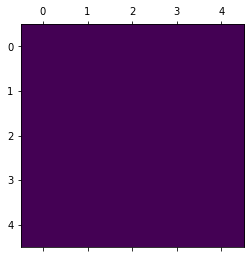

In [ ]:
import numpy as np
import multiprocessing
import random
import pickle
import time

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

n = 5
globalIterations = 5
movI = [-1, -1, 0, 1, 1, 1, 0, -1]
movJ = [0, 1, 1, 1, 0, -1, -1, -1]

queues = np.empty((n,n),dtype=object)
carobnjakQueue = multiprocessing.Queue()

#nextIter = multiprocessing.Value('i', 0)

threadMatrix = np.empty((n,n),dtype=object)
globalMatrix = np.empty((globalIterations, n, n),dtype=object)

resQueue = multiprocessing.Queue()

counterQueue = multiprocessing.Queue()
getQueue = multiprocessing.Queue()

class Cell:
    hasBeenRead = 8
    iteration = 0
    value = 0
    aliveAround = 0

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.value = random.randint(0,1)
        #self.value = 0
        #if (self.x == 5 and self.y == 3) or (self.x == 5 and self.y == 4) or (self.x == 5 and self.y == 5) or (self.x == 4 and self.y == 4):
        #  self.value = 1
        #if (x == 1 and y == 0) or (x == 1 and y == 1) or (x == 1 and y == 2):
        #    self.value = 1
        if (x == 0 and y == 0) or (x == 0 and y == n-1) or (x == n-1 and y == 0) or (x == n-1 and y == n-1):
            self.hasBeenRead = 3
        elif x == 0 or x == n-1 or y == 0 or y == n-1:
            self.hasBeenRead = 5

    def writeAndRead(self, queues, carobnjakQueue,counterQueue, getQueue):
        for i in range(globalIterations):
            #nextIter.value = 0
            for j in range(8):
                if n > self.x+movI[j] >= 0 and n > self.y + movJ[j] >= 0:
                    queues[self.x + movI[j]][self.y + movJ[j]].put(self.value)
            for j in range(self.hasBeenRead):
                if queues[self.x][self.y].get() == 1:
                    self.aliveAround += 1

            serialize = pickle.dumps(self)

            if self.value == 1:
                if self.aliveAround > 3 or self.aliveAround < 2:
                    self.value = 0
            else:
                if self.aliveAround == 3:
                    self.value = 1
            self.aliveAround = 0
            self.iteration += 1

            carobnjakQueue.put(serialize)

            position = counterQueue.get()
            print("counter got {0}".format(position))
            getQueue.put(1)

            if position != (n*n)-1:
                print("put {0} into counter".format(position+1))
                counterQueue.put(position + 1)
                while not getQueue.empty():
                    time.sleep(0.01)
                time.sleep(0.01)
                print("exited sleep")
            else:
                print("last one waking up others...")
                for k in range(position+1):
                    getQueue.get()
                #print("woke up all others")
                counterQueue.put(0)

def carobnjak(carobnjakQueue,resQueue):
    matrix = np.zeros((globalIterations, n, n), dtype=int)
    for i in range(globalIterations):
        for j in range(n*n):
            cell = carobnjakQueue.get()
            deserialize = pickle.loads(cell)
            matrix[deserialize.iteration][deserialize.x][deserialize.y] = deserialize.value
        #nextIter.value = 1
    serialize = pickle.dumps(matrix)
    resQueue.put(serialize)

def animate(steps):
    ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije)
    prikazuje razvoj sistema'''

    def init():
        im.set_data(steps[0])
        return [im]

    def animate(i):
        im.set_data(steps[i])
        return [im]

    im = plt.matshow(steps[0], interpolation='None', animated=True)

    anim = FuncAnimation(im.get_figure(), animate, init_func=init,frames=len(steps), interval=500, blit=True, repeat=False)
    return anim

for i in range(n):
    for j in range(n):
        queue = multiprocessing.Queue()
        queues[i][j] = queue

if __name__ == '__main__':
    counterQueue.put(0)
    carobnjakProcess = multiprocessing.Process(target=carobnjak, args=(carobnjakQueue,resQueue)) #,kwargs={'nextIter':nextIter}

    for i in range(n):
        for j in range(n):
            cell = Cell(i, j)
            threadMatrix[i][j] = multiprocessing.Process(target=cell.writeAndRead, args=(queues,carobnjakQueue,counterQueue,getQueue)) #,kwargs={'nextIter':nextIter}

    carobnjakProcess.start()

    for i in range(n):
        for j in range(n):
            threadMatrix[i][j].start()

    for i in range(n):
        for j in range(n):
            threadMatrix[i][j].join()
    carobnjakProcess.join()

    deserialize1 = resQueue.get()
    globalMatrix = pickle.loads(deserialize1)
    #print(globalMatrix)

anim = animate(globalMatrix)
HTML(anim.to_html5_video())

3. Implemented using a pool from the class "multiprocessing".

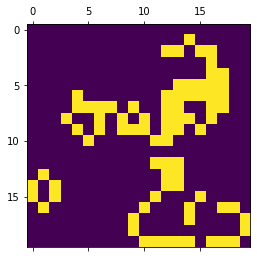

In [ ]:
import multiprocessing as mp
import numpy as np
import random

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

n = 20
globalIterations = 20

movI = [-1, -1, 0, 1, 1, 1, 0, -1]
movJ = [0, 1, 1, 1, 0, -1, -1, -1]

cpus = mp.cpu_count()
N = cpus

totalNumber = n**2

matrix = np.empty((n,n), dtype=int)
matrixArray = []


def function(task, matrix):
    #print("task : ")
    #print(task)
    coordinates = []

    for tup in task:
        x = tup[0]
        y = tup[1]
        aliveAround = 0
        for i in range(8):
            if n > x+movI[i] >= 0 and n > y + movJ[i] >= 0:
                value = matrix[x + movI[i]][y + movJ[i]]
                if value == 1:
                    aliveAround += 1
        if matrix[x][y] == 1:
            #if x == 2 and y == 3:
                #print("ziv")
            if aliveAround > 3 or aliveAround < 2:
                coordinates.append((x,y,0))
            else:
                coordinates.append((x,y,1))
        else:
            #if x == 2 and y == 3:
                #print(matrix[x][y])
            if aliveAround == 3:
                coordinates.append((x,y,1))
                #if x == 2 and y == 3:
                    #print("apendovao 1")
            else:
                coordinates.append((x,y,0))
                #if x == 2 and y == 3:
                    #print("apendovao 0")
    return coordinates

def animate(steps):
    ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije)
    prikazuje razvoj sistema'''

    def init():
        im.set_data(steps[0])
        return [im]

    def animate(i):
        im.set_data(steps[i])
        return [im]

    im = plt.matshow(steps[0], interpolation='None', animated=True);

    anim = FuncAnimation(im.get_figure(), animate, init_func=init,frames=len(steps), interval=500, blit=True, repeat=False);
    return anim

if __name__ == '__main__':
    matrixArray = np.empty((globalIterations,n,n), dtype=int)
    tasks = []
    results = []
    numberOfSubets = totalNumber//N

    for i in range(n):
        for j in range(n):
            #matrix[i][j] = 0
            matrix[i][j] = random.randint(0,1)

    #matrix[5][3] = 1
    #matrix[5][4] = 1
    #matrix[5][5] = 1
    #matrix[4][4] = 1  

    for p in range(n):
        for q in range(n):
            matrixArray[0][p][q] = matrix[p][q]

    cell_subset = []
    counter = 0
    index = 0
    for i in range(n):
        for j in range(n):
            cell_subset.append((i, j))
            counter += 1
            if counter == numberOfSubets:
                temp = cell_subset
                tasks.append(temp)
                counter = 0
                cell_subset = []

    if len(cell_subset) != 0:
        tasks.append(cell_subset)

    # Process pool
    pool = mp.Pool(cpus)

    for i in range(globalIterations):
        for task in tasks:
            res = pool.apply(function, args=(task, matrix))
            for j in range(len(res)):
                results.append(res[j])

        #for cord in results:
        for tup in results:
            matrix[tup[0]][tup[1]] = tup[2]

        results.clear()

        for p in range(n):
            for q in range(n):
                matrixArray[i][p][q] = matrix[p][q]

    pool.close()
    pool.join()
    #print(matrixArray)

anim = animate(matrixArray)
HTML(anim.to_html5_video())